In [45]:
import pandas as pd
import numpy as np
from os.path import join, dirname
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [85]:
# Load all data files and merge them into a DataFrame
data = pd.read_csv("./data/data_last.csv", header=0)
vol = pd.read_csv("./data/data_volume.csv", header=0)
data = data.merge(vol)
mkt_cap = pd.read_csv("./data/data_mkt_cap.csv", header=0)
data = data.merge(mkt_cap)
data['mkt_cap'] = np.log(data['mkt_cap']) # Logarithm to market capital
data

,ticker,date,last,volume,mkt_cap
0,1332 JT,2017-08-16,562.12,1641300.0,12.204286
1,1332 JT,2017-08-17,560.36,1247700.0,12.201151
2,1332 JT,2017-08-18,553.32,1505800.0,12.188513
3,1332 JT,2017-08-21,544.53,2046200.0,12.172487
4,1332 JT,2017-08-22,535.73,2409300.0,12.156200
...,...,...,...,...,...
420532,9984 JT,2024-02-29,8790.00,10544100.0,16.374384
420533,9984 JT,2024-03-01,8907.00,12555200.0,16.387607
420534,9984 JT,2024-03-04,8934.00,12317400.0,16.390634
420535,9984 JT,2024-03-05,9008.00,10072900.0,16.398883


In [86]:
# Set up sector variable
sec = pd.read_csv("./data/data_sector.csv", header=0)
sec_list = sec['bics_sector'].unique().tolist()
for i in sec_list:
    sec[i] = np.where(sec['bics_sector'] == i, 1, 0)
sec = sec.drop(['bics_sector'], axis=1)
data = data.merge(sec, on='ticker', how='left')
data.sort_values(by=['ticker', 'date'], inplace=True)

# Calculate return (t to t+1)
data['ret'] = data.groupby('ticker')['last'].pct_change().shift(-1)
data

,ticker,date,last,volume,mkt_cap,"Consumer, Non-cyclical",Energy,Industrial,"Consumer, Cyclical",Communications,Technology,Financial,Basic Materials,Utilities,ret
0,1332 JT,2017-08-16,562.12,1641300.0,12.204286,1,0,0,0,0,0,0,0,0,-0.003131
1,1332 JT,2017-08-17,560.36,1247700.0,12.201151,1,0,0,0,0,0,0,0,0,-0.012563
2,1332 JT,2017-08-18,553.32,1505800.0,12.188513,1,0,0,0,0,0,0,0,0,-0.015886
3,1332 JT,2017-08-21,544.53,2046200.0,12.172487,1,0,0,0,0,0,0,0,0,-0.016161
4,1332 JT,2017-08-22,535.73,2409300.0,12.156200,1,0,0,0,0,0,0,0,0,0.016426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420532,9984 JT,2024-02-29,8790.00,10544100.0,16.374384,0,0,0,0,1,0,0,0,0,0.013311
420533,9984 JT,2024-03-01,8907.00,12555200.0,16.387607,0,0,0,0,1,0,0,0,0,0.003031
420534,9984 JT,2024-03-04,8934.00,12317400.0,16.390634,0,0,0,0,1,0,0,0,0,0.008283
420535,9984 JT,2024-03-05,9008.00,10072900.0,16.398883,0,0,0,0,1,0,0,0,0,-0.014876


In [87]:
# Construct factors
# To avoid look-ahead bias, use data from t-n to t-1 to calculate the factor on t
def BIAS(df):
    return ((df['last']-df['last'].rolling(window=10).mean())/df['last'].rolling(window=10).mean()).shift(1)

def VSTD(df):
    return (df['volume'].rolling(window=10).std()).shift(1)

def VCCorr(df):
    return df['last'].rolling(window=10).corr(df['volume']).shift(1)

def MACD(df):
    # DIF = EMA(close,12) - EMA(close,26)
    diff = df['last'].ewm(span=12).mean() - df['last'].ewm(span=26).mean()
    # DEA = EMA(DIF,9)
    dea = diff.ewm(span=9).mean()
    macd = (diff-dea)*2
    return macd.shift(1)

def VEMA(df):
    return df['volume'].ewm(span=20).mean().shift(1)

data['BIAS'] = data.groupby('ticker').apply(BIAS).values
data['VSTD'] = data.groupby('ticker').apply(VSTD).values
data['VCCorr'] = data.groupby('ticker').apply(VCCorr).values
data['MACD'] = data.groupby('ticker').apply(MACD).values
data['VEMA'] = data.groupby('ticker').apply(VEMA).values
data

,ticker,date,last,volume,mkt_cap,"Consumer, Non-cyclical",Energy,Industrial,"Consumer, Cyclical",Communications,Technology,Financial,Basic Materials,Utilities,ret,BIAS,VSTD,VCCorr,MACD,VEMA
0,1332 JT,2017-08-16,562.12,1641300.0,12.204286,1,0,0,0,0,0,0,0,0,-0.003131,NaN,NaN,NaN,NaN,NaN
1,1332 JT,2017-08-17,560.36,1247700.0,12.201151,1,0,0,0,0,0,0,0,0,-0.012563,NaN,NaN,NaN,0.000000,1.641300e+06
2,1332 JT,2017-08-18,553.32,1505800.0,12.188513,1,0,0,0,0,0,0,0,0,-0.015886,NaN,NaN,NaN,-0.035100,1.434660e+06
3,1332 JT,2017-08-21,544.53,2046200.0,12.172487,1,0,0,0,0,0,0,0,0,-0.016161,NaN,NaN,NaN,-0.291172,1.460782e+06
4,1332 JT,2017-08-22,535.73,2409300.0,12.156200,1,0,0,0,0,0,0,0,0,0.016426,NaN,NaN,NaN,-0.741361,1.629783e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420532,9984 JT,2024-02-29,8790.00,10544100.0,16.374384,0,0,0,0,1,0,0,0,0,0.013311,0.037535,3.338527e+06,-0.296526,165.045053,1.494176e+07
420533,9984 JT,2024-03-01,8907.00,12555200.0,16.387607,0,0,0,0,1,0,0,0,0,0.003031,0.015528,3.175464e+06,-0.129740,106.835781,1.452294e+07
420534,9984 JT,2024-03-04,8934.00,12317400.0,16.390634,0,0,0,0,1,0,0,0,0,0.008283,0.024252,3.078528e+06,-0.110455,69.516291,1.433553e+07
420535,9984 JT,2024-03-05,9008.00,10072900.0,16.398883,0,0,0,0,1,0,0,0,0,-0.014876,0.020096,3.003675e+06,-0.000623,35.600840,1.414333e+07


In [88]:
# Data Processing
def data_processing(df, factor_name, std=3):
    # winsorize
    factor = df[factor_name]
    edge_up = factor.mean() + std * factor.std()
    edge_low = factor.mean()- std * factor.std()
    factor[factor>edge_up] = edge_up
    factor[factor<edge_low] = edge_low
    
    # standardize
    factor = (factor - factor.mean())/factor.std()
    
    # neutralization
    x = df[['mkt_cap']+sec_list]
    result = sm.OLS(factor, x.astype(float)).fit()
    return result.resid


clean_data = data.dropna(how='any')
factor_list = ['BIAS', 'VSTD', 'VCCorr', 'MACD', 'VEMA']
for factor_name in factor_list:
    clean_data[factor_name] = clean_data.groupby('date').apply(lambda x: data_processing(x, factor_name)).droplevel('date').sort_index()
clean_data

,ticker,date,last,volume,mkt_cap,"Consumer, Non-cyclical",Energy,Industrial,"Consumer, Cyclical",Communications,Technology,Financial,Basic Materials,Utilities,ret,BIAS,VSTD,VCCorr,MACD,VEMA
10,1332 JT,2017-08-30,549.80,2558300.0,12.182133,1,0,0,0,0,0,0,0,0,-0.009585,-0.807009,0.633717,-1.819444,0.007038,0.793476
11,1332 JT,2017-08-31,544.53,1401900.0,12.172487,1,0,0,0,0,0,0,0,0,-0.009696,0.303176,0.639708,-1.529794,-0.207462,0.809995
12,1332 JT,2017-09-01,539.25,1393400.0,12.162746,1,0,0,0,0,0,0,0,0,-0.006528,-0.416671,0.447053,-1.047475,-0.452466,0.760441
13,1332 JT,2017-09-04,535.73,1697900.0,12.156200,1,0,0,0,0,0,0,0,0,-0.014784,-1.176716,0.415382,-0.502466,-0.686106,0.726177
14,1332 JT,2017-09-05,527.81,1735200.0,12.141311,1,0,0,0,0,0,0,0,0,0.013338,-0.515608,0.439157,-0.376516,-0.552030,0.733952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420531,9984 JT,2024-02-28,8920.00,9335600.0,16.389066,0,0,0,0,1,0,0,0,0,-0.014574,1.709743,1.291735,-0.140634,2.427953,0.051231
420532,9984 JT,2024-02-29,8790.00,10544100.0,16.374384,0,0,0,0,1,0,0,0,0,0.013311,1.148766,-0.485088,-0.773116,2.031232,0.002522
420533,9984 JT,2024-03-01,8907.00,12555200.0,16.387607,0,0,0,0,1,0,0,0,0,0.003031,0.583305,-0.570042,-0.389198,1.369945,-0.085132
420534,9984 JT,2024-03-04,8934.00,12317400.0,16.390634,0,0,0,0,1,0,0,0,0,0.008283,0.480470,-0.545871,-0.361051,0.744353,-0.106373


In [89]:
# Multi-factors model
# Use linear regression to predict return by 5 factors
# Model is updated weekly (every 5 trading days)
datelist = clean_data['date'].unique()
pred_res = pd.DataFrame()
period = 5
for i in range(0, len(datelist)//period):
    print('Train period: ', datelist[i*period], 'to ', datelist[i*period+period-1])
    pred_start = datelist[(i+1)*period]
    pred_end = datelist[-1] if (i+2)*period > len(datelist) else datelist[(i+1)*period+period-1]
    print('Predict period: ', pred_start, 'to ', pred_end)
    Train_data = clean_data[(clean_data['date']>=datelist[i*period])&(clean_data['date']<=datelist[i*period+period-1])]
    Pred_data = clean_data[(clean_data['date']>=pred_start)&(clean_data['date']<=pred_end)]
    model = sm.OLS(Train_data['ret'], Train_data[factor_list]).fit()
    pred = model.predict(Pred_data[factor_list])
    pred_res = pd.concat([pred_res, pred])
pred_res = pred_res.sort_index()
pred_res

Train period:  2017-08-30 to  2017-09-05
Predict period:  2017-09-06 to  2017-09-12
Train period:  2017-09-06 to  2017-09-12
Predict period:  2017-09-13 to  2017-09-20
Train period:  2017-09-13 to  2017-09-20
Predict period:  2017-09-21 to  2017-09-27
Train period:  2017-09-21 to  2017-09-27
Predict period:  2017-09-28 to  2017-10-04
Train period:  2017-09-28 to  2017-10-04
Predict period:  2017-10-05 to  2017-10-12
Train period:  2017-10-05 to  2017-10-12
Predict period:  2017-10-13 to  2017-10-19
Train period:  2017-10-13 to  2017-10-19
Predict period:  2017-10-20 to  2017-10-26
Train period:  2017-10-20 to  2017-10-26
Predict period:  2017-10-27 to  2017-11-02
Train period:  2017-10-27 to  2017-11-02
Predict period:  2017-11-06 to  2017-11-10
Train period:  2017-11-06 to  2017-11-10
Predict period:  2017-11-13 to  2017-11-17
Train period:  2017-11-13 to  2017-11-17
Predict period:  2017-11-20 to  2017-11-27
Train period:  2017-11-20 to  2017-11-27
Predict period:  2017-11-28 to  201

,0
15,-0.000012
16,-0.000125
17,-0.000207
18,-0.000207
19,-0.000163
...,...
420531,0.004289
420532,-0.001965
420533,0.001078
420534,0.000447


In [93]:
# Calculate IC and IR of predictions
def IC(df):
    return df['ret'].corr(df['pred'], method='spearman')
test_data = clean_data.merge(pred_res, left_index=True, right_index=True)
test_data.rename(columns={0:'pred'}, inplace=True)
IC = test_data.groupby('date').apply(IC)
print(IC)
print('IC mean: ', IC.mean())
print('IR: ', IC.mean()/IC.std())

date
2017-09-06   -0.049435
2017-09-07    0.007710
2017-09-08   -0.045201
2017-09-11    0.109610
2017-09-12   -0.012917
                ...   
2024-02-28   -0.071006
2024-02-29   -0.056352
2024-03-01    0.149996
2024-03-04    0.122690
2024-03-05    0.095033
Length: 1583, dtype: float64
IC mean:  0.0006974452263052238
IR:  0.006177964329778107


In [145]:
# Backtest
# Every day, choose 10 stocks with the highest predictions and equally weighted
num = 10
def allocate_weight(df):
    temp = df.copy()
    temp.index = temp.ticker
    temp['rank'] = temp['pred'].rank()
    temp['weight'] = np.where(temp['rank']<=num, 1/num, 0)
    return temp['weight']
weight = test_data.groupby('date').apply(allocate_weight).unstack()
weight.fillna(0, inplace=True)
weight

ticker,1332 JT,1333 JT,1605 JT,1721 JT,1801 JT,1802 JT,1803 JT,1808 JT,1812 JT,1925 JT,...,9531 JT,9532 JT,9602 JT,9613 JT,9681 JT,9735 JT,9766 JT,9843 JT,9983 JT,9984 JT
date,,,,,,,,,,,,,,,,,,,,,
2017-09-06,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-07,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-08,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0
2017-09-11,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0
2017-09-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
ret = test_data[['date', 'ticker', 'ret']].set_index(['date', 'ticker']).unstack()
ret = ret.droplevel(None, axis=1)
ret.fillna(0, inplace=True)
ret

ticker,1332 JT,1333 JT,1605 JT,1721 JT,1801 JT,1802 JT,1803 JT,1808 JT,1812 JT,1925 JT,...,9531 JT,9532 JT,9602 JT,9613 JT,9681 JT,9735 JT,9766 JT,9843 JT,9983 JT,9984 JT
date,,,,,,,,,,,,,,,,,,,,,
2017-09-06,0.011517,0.000000,0.009463,0.000401,0.014260,0.009278,0.015921,0.008588,0.014705,0.002973,...,0.000176,0.000943,-0.003862,-0.004330,-0.007921,-0.005965,-0.003566,0.013466,0.004907,-0.006878
2017-09-07,-0.003253,0.004770,-0.003750,0.010902,-0.004394,-0.002296,0.014790,0.010636,0.001938,-0.008629,...,0.000352,-0.002356,-0.001290,-0.009564,-0.000989,0.001750,-0.016098,0.010977,-0.023437,-0.009273
2017-09-08,0.004896,0.047469,-0.004705,0.017170,0.011475,0.003065,0.012867,0.003514,0.004821,0.023391,...,0.008798,0.002362,0.007761,0.022820,0.012972,0.010731,0.012726,0.028000,0.020333,0.007940
2017-09-11,0.011368,-0.010575,0.005673,-0.007068,-0.000873,-0.015298,-0.006771,-0.027278,-0.015360,-0.001596,...,0.006456,-0.000471,-0.001282,-0.003429,0.026600,0.011482,0.014363,-0.000556,0.045410,0.011871
2017-09-12,-0.009634,0.006107,0.005176,0.005935,0.012226,-0.003886,-0.002560,0.002880,-0.008771,-0.001331,...,0.005024,0.011332,-0.001287,0.015506,0.011512,-0.001952,0.017699,0.001112,-0.012813,0.003369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-28,0.001577,0.013884,0.005249,-0.009290,-0.009678,0.005899,-0.015413,-0.010670,0.007070,0.002083,...,-0.043186,-0.016103,-0.007755,-0.016959,0.000000,-0.004104,-0.000991,0.010342,0.001157,-0.014574
2024-02-29,-0.001575,-0.009129,0.028344,0.025408,0.002762,0.020352,0.002647,0.006471,0.005941,0.012009,...,0.009454,0.022712,0.001440,0.007599,0.000000,0.029304,0.017361,0.014786,0.025659,0.013311
2024-03-01,-0.006519,-0.034636,0.006044,0.006195,-0.008898,-0.014875,-0.008151,-0.015269,-0.012527,-0.007303,...,-0.004834,-0.005552,0.000205,0.007746,0.000000,0.006228,0.000975,-0.013450,-0.004508,0.003031


In [147]:
# Calculate weight changes before rebalancing
weight_before_reb = weight * (1 + ret)
# Calculate weight changes
weight_change = weight - weight_before_reb.shift(1)
weight_change.iloc[0] = weight.iloc[0]
weight_change = weight_change.apply(lambda x: abs(x).sum(), axis=1)
weight_change

date
2017-09-06    1.000000
2017-09-07    0.208575
2017-09-08    0.208511
2017-09-11    0.214405
2017-09-12    0.616202
                ...   
2024-02-28    0.613810
2024-02-29    0.607110
2024-03-01    2.008751
2024-03-04    0.408888
2024-03-05    0.404537
Length: 1583, dtype: float64

In [148]:
# NAV
# Considering transaction costs
fee = [0, 1/10000, 2/10000, 3/10000]
nav = dict()
for f in fee:
    portfolio_ret = (weight * ret).apply(lambda x: x.sum(), axis=1)
    portfolio_ret = (portfolio_ret + 1) * (1 - weight_change * f)
    portfolio_ret.loc['2024-03-06']=0
    portfolio_ret = portfolio_ret.shift(1)
    portfolio_ret.iloc[0] = 1
    cumret = portfolio_ret.cumprod()
    nav[f] = cumret

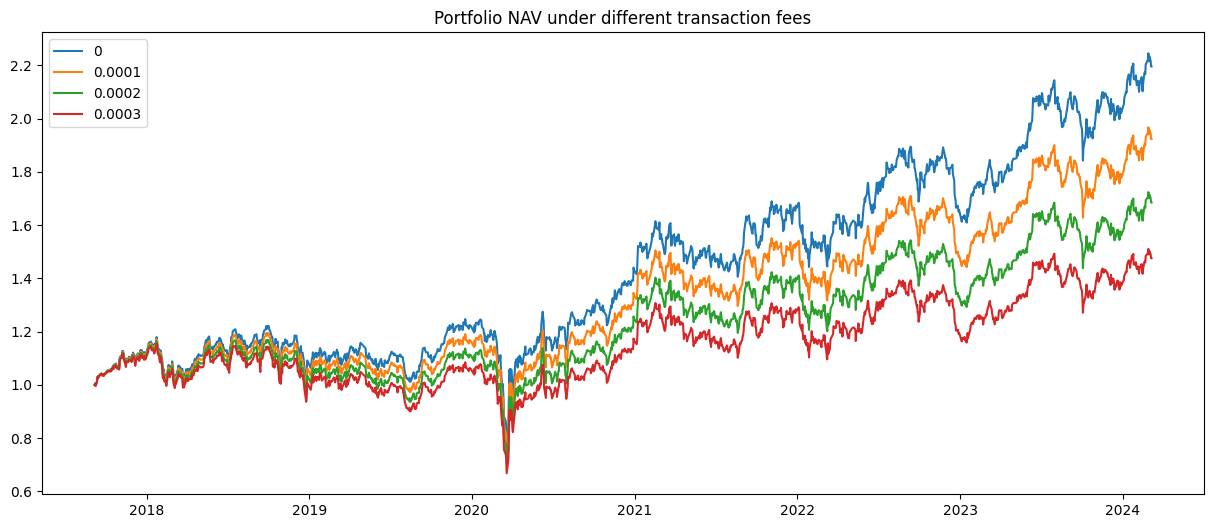

In [149]:
# Plot NAV curve
plt.figure(figsize=(15,6))
plt.title('Portfolio NAV under different transaction fees')
for f in fee:
    plt.plot(pd.to_datetime(nav[f].index), nav[f], label=f)
plt.legend()
plt.show()

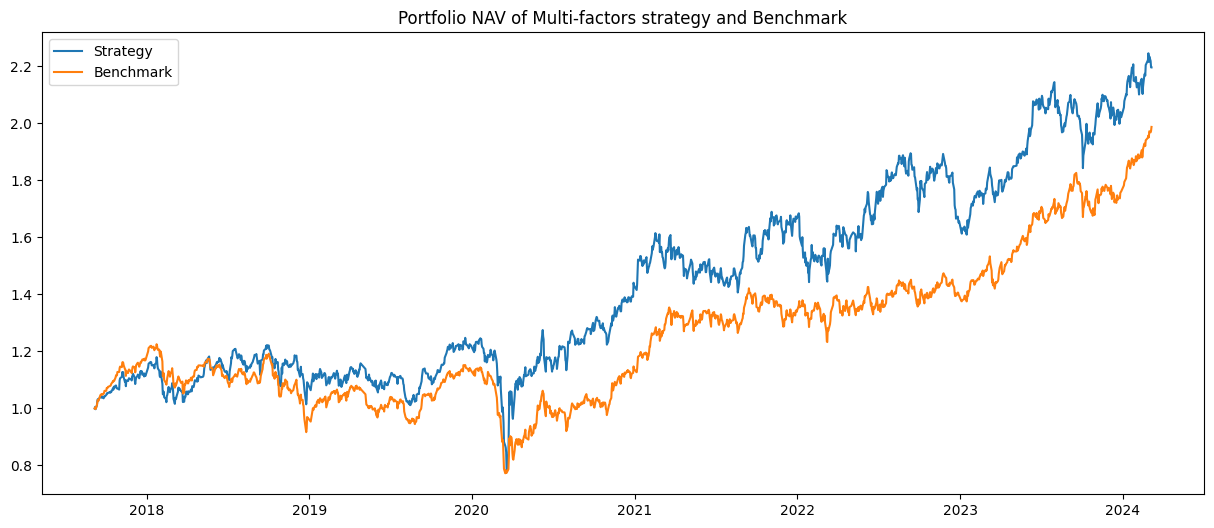

In [151]:
# The following analysis doesn't take transaction cost into account
# Compare the strategy with the equally weighted all stock strategy (benchmark)
benchmark = ret.apply(lambda x: x.mean(), axis=1)
benchmark.loc['2024-03-06']=0
benchmark = benchmark.shift(1)
benchmark.iloc[0] = 0
benchmark_cumret = (benchmark+1).cumprod()
plt.figure(figsize=(15,6))
plt.title('Portfolio NAV of Multi-factors strategy and Benchmark')
plt.plot(pd.to_datetime(nav[0].index), nav[0], label='Strategy')
plt.plot(pd.to_datetime(benchmark_cumret.index), benchmark_cumret, label='Benchmark')
plt.legend()
plt.show()

In [166]:
# annualized return
def annualized_return(ret):
    last_nav = (ret + 1).cumprod().iloc[-1]
    num_years = len(ret) / 252 
    annualized_return = last_nav ** (1 / num_years) - 1
    return annualized_return

# annualized volatility
def annualized_volatility(ret):
    # transform daily volatility into annualized form
    annualized_vol = ret.std() * np.sqrt(252)
    return annualized_vol

def sharpe_ratio(ret, risk_free_rate=0.02):
    mean_return = ret.mean()
    vol = ret.std()
    # transform rf into daily rf
    risk_free_rate_daily = (1 + risk_free_rate) ** (1/252) - 1
    # Calculate annualized Sharpe Ratio
    sharpe = (mean_return - risk_free_rate_daily) / vol * np.sqrt(252)
    return sharpe

def max_drawdown(ret):
    cumret = (ret + 1).cumprod()
    maxdrawdown_rate = ((cumret.cummax() - cumret) / cumret.cummax()).max()
    return maxdrawdown_rate


portfolio_ret = (weight * ret).apply(lambda x: x.sum(), axis=1)
benchmark_ret = ret.apply(lambda x: x.mean(), axis=1)
ret_dict = {'Strategy': portfolio_ret, 'Benchmark': benchmark_ret}
df = pd.DataFrame(columns=['Annualized Return', 'Annualized Vol', 'Sharpe Ratio', 'Max Drawdown'],
                  index=['Strategy', 'Benchmark'])
for i in df.index:
    df.loc[i, 'Annualized Return'] = annualized_return(ret_dict[i])
    df.loc[i, 'Annualized Vol'] = annualized_volatility(ret_dict[i])
    df.loc[i, 'Sharpe Ratio'] = sharpe_ratio(ret_dict[i])
    df.loc[i, 'Max Drawdown'] = max_drawdown(ret_dict[i])

df

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Strategy,0.133397,0.222511,0.584428,0.374773
Benchmark,0.11552,0.177869,0.592322,0.369514
